<a href="https://colab.research.google.com/github/StanleyLiangYork/Advance_NN_techniques/blob/main/Bed_occupancy_prediction_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use the original feature without cyclical features

In [ ]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
import random
# set the numpy only output 3-digit after decimal point
np.set_printoptions(precision=3, suppress=True)
print(tf.__version__)

2.8.0


In [ ]:
!wget https://storage.googleapis.com/pet-detect-239118/bed_occupancy/bed_occupancy_1.csv ./bed_occupancy_1.csv

--2022-05-24 15:28:28--  https://storage.googleapis.com/pet-detect-239118/bed_occupancy/bed_occupancy_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40454 (40K) [text/csv]
Saving to: ‘bed_occupancy_1.csv’

bed_occupancy_1.csv 100%[===================>]  39.51K  --.-KB/s    in 0.001s  

2022-05-24 15:28:28 (63.7 MB/s) - ‘bed_occupancy_1.csv’ saved [40454/40454]

--2022-05-24 15:28:28--  http://./bed_occupancy_1.csv
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-05-24 15:28:28--
Total wall clock time: 0.2s
Downloaded: 1 files, 40K in 0.001s (63.7 MB/s)


In [ ]:
dataset = pd.read_csv('/content/bed_occupancy_1.csv')
dataset = dataset.dropna()
print(dataset.isna().sum())
print(dataset.shape)

Date                       0
Facility                   0
Location Mnemonic          0
TotFundedBeds              0
TotDischarges              0
TotInpatientCensusDays     0
TotInpatientServiceDays    0
ICDOccupancyDaily          0
dtype: int64
(1095, 8)


In [ ]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.sort_values(by=['Date'], inplace=True)
dataset = dataset.set_index('Date')
print(dataset.shape)

(1095, 7)


In [ ]:
dataset.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='Date', length=1095, freq=None)

In [ ]:
date_time = pd.to_datetime(dataset.index, format='%Y-%m-%d')
df = dataset[['TotDischarges', 'TotInpatientCensusDays','TotInpatientServiceDays', 'ICDOccupancyDaily']]

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
train_df = df[0:int(n*0.80)]
val_df = df[int(n*0.80):int(n*0.90)]
test_df = df[int(n*0.90):]
num_features = df.shape[1]

In [ ]:
train_mean = df.mean()
train_std = df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

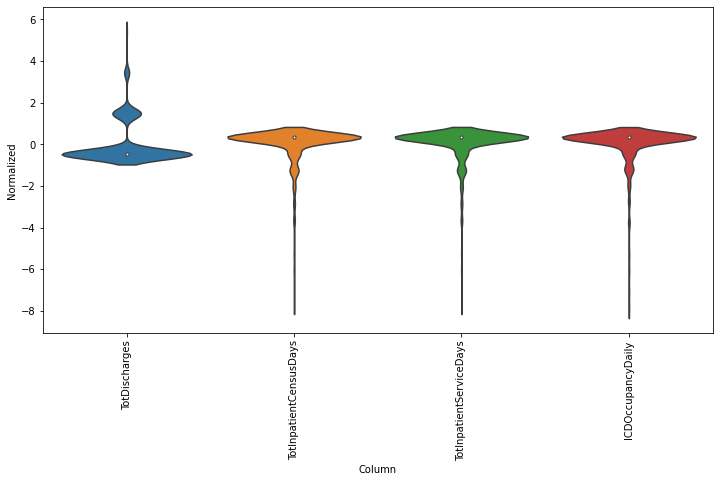

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='ICDOccupancyDaily', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=256,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
train_df.columns

Index(['TotDischarges', 'TotInpatientCensusDays', 'TotInpatientServiceDays',
       'ICDOccupancyDaily'],
      dtype='object')

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1, label_columns=['ICDOccupancyDaily'])

In [ ]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['ICDOccupancyDaily']

In [ ]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1, label_columns=['ICDOccupancyDaily'])

In [ ]:
wide_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['ICDOccupancyDaily']

Define the baseline model - use the next step value as the predicted value

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsolutePercentageError()])

In [ ]:
val_performance = {}
performance = {}
print("Evaluating Baseline model ...")
val_performance['Baseline'] = baseline.evaluate(wide_window.val, verbose=2)
print("Testing Baseline model ...")
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=2)

Evaluating Baseline model ...
1/1 - 1s - loss: 0.2730 - mean_absolute_error: 0.2610 - mean_squared_error: 0.2730 - root_mean_squared_error: 0.5225 - mean_absolute_percentage_error: 76.6062 - 1s/epoch - 1s/step
Testing Baseline model ...
1/1 - 0s - loss: 0.3351 - mean_absolute_error: 0.2674 - mean_squared_error: 0.3351 - root_mean_squared_error: 0.5789 - mean_absolute_percentage_error: 78.9040 - 68ms/epoch - 68ms/step


Define the train function

In [ ]:
MAX_EPOCHS = 200

In [ ]:
def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=0.0004),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsolutePercentageError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping], verbose=0)
  return history

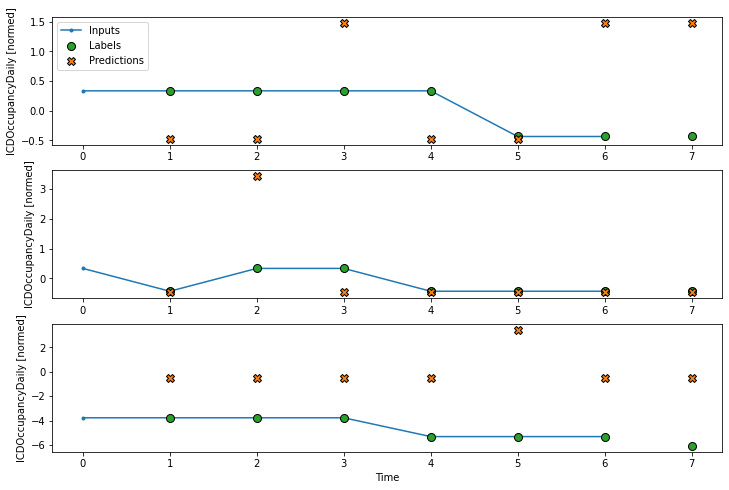

In [ ]:
wide_window.plot(baseline)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (256, 7, 4)
Output shape: (256, 7, 4)


In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 80ms/step - loss: 0.0286 - mean_absolute_error: 0.0769 - mean_squared_error: 0.0286 - root_mean_squared_error: 0.1692 - mean_absolute_percentage_error: 21.5445


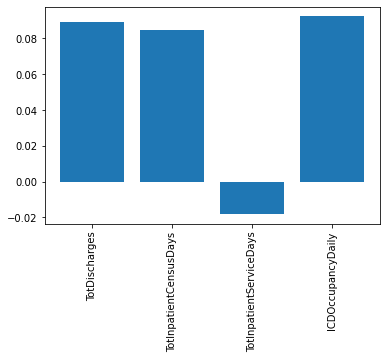

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=dense.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Multi_step model

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
CONV_WIDTH = 3
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['ICDOccupancyDaily'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [1 2 3]
Label column name(s): ['ICDOccupancyDaily']

In [ ]:
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['ICDOccupancyDaily'])

wide_conv_window

Total window size: 10
Input indices: [0 1 2 3 4 5 6 7 8]
Label indices: [3 4 5 6 7 8 9]
Label column name(s): ['ICDOccupancyDaily']

Convolution neural network

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
history = compile_and_fit(conv_model, wide_conv_window)

val_performance['Conv'] = conv_model.evaluate(wide_conv_window.val)
performance['Conv'] = conv_model.evaluate(wide_conv_window.test, verbose=0)

1/1 [==============================] - 0s 70ms/step - loss: 0.0228 - mean_absolute_error: 0.0715 - mean_squared_error: 0.0228 - root_mean_squared_error: 0.1511 - mean_absolute_percentage_error: 19.6357


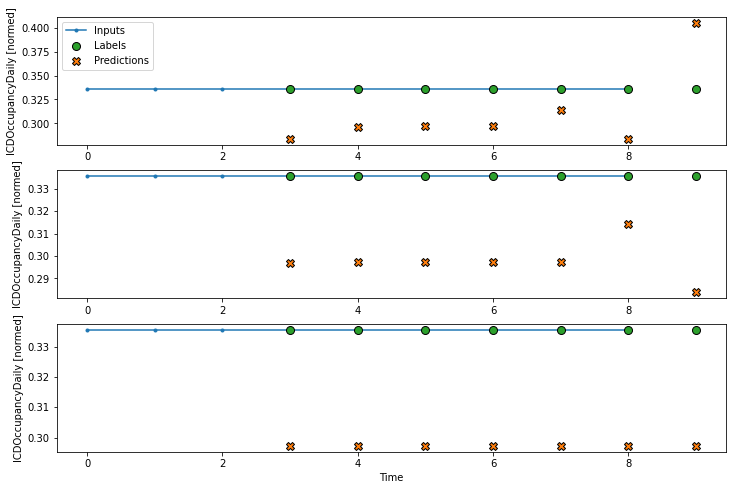

In [ ]:
wide_conv_window.plot(conv_model)

Recurrent Neural Network

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(lstm_model, wide_window)
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 83ms/step - loss: 0.0272 - mean_absolute_error: 0.0798 - mean_squared_error: 0.0272 - root_mean_squared_error: 0.1650 - mean_absolute_percentage_error: 22.2237


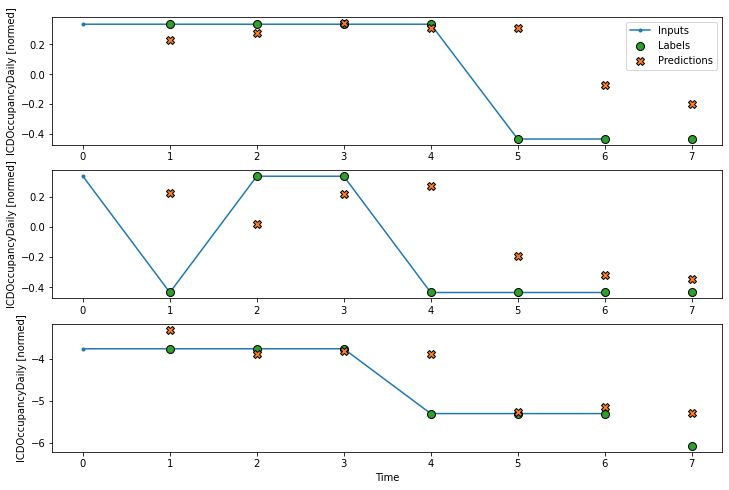

In [ ]:
wide_window.plot(lstm_model)

CNN+LSTM

In [ ]:
cnn_lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(cnn_lstm_model, wide_conv_window)
val_performance['CNN+LSTM'] = cnn_lstm_model.evaluate(wide_conv_window.val)
performance['CNN+LSTM'] = cnn_lstm_model.evaluate(wide_conv_window.test, verbose=0)

1/1 [==============================] - 0s 88ms/step - loss: 0.0238 - mean_absolute_error: 0.0693 - mean_squared_error: 0.0238 - root_mean_squared_error: 0.1544 - mean_absolute_percentage_error: 18.9138


Autoregressive model

AR LSTM

In [ ]:
class AR_LSTM(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
OUT_STEPS = 1

ar_lstm_model = AR_LSTM(units=64, out_steps=OUT_STEPS)

In [ ]:
def warmup_ar(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

AR_LSTM.warmup = warmup_ar

In [ ]:
def call_ar(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

AR_LSTM.call = call_ar

In [ ]:
history = compile_and_fit(ar_lstm_model, wide_window)

val_performance['AR LSTM'] = ar_lstm_model.evaluate(wide_window.val)
performance['AR LSTM'] = ar_lstm_model.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 79ms/step - loss: 0.0197 - mean_absolute_error: 0.0573 - mean_squared_error: 0.0197 - root_mean_squared_error: 0.1402 - mean_absolute_percentage_error: 15.3301


AR CNN+LSTM

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.conv_layer = tf.keras.layers.Conv1D(64, kernel_size=(3,), activation='relu')
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
OUT_STEPS = 1

feedback_model = FeedBack(units=64, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(self.conv_layer(inputs))

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
history = compile_and_fit(feedback_model, wide_conv_window)

val_performance['AR CNN+LSTM'] = feedback_model.evaluate(wide_conv_window.val)
performance['AR CNN+LSTM'] = feedback_model.evaluate(wide_conv_window.test, verbose=0)

1/1 [==============================] - 0s 80ms/step - loss: 0.0194 - mean_absolute_error: 0.0512 - mean_squared_error: 0.0194 - root_mean_squared_error: 0.1392 - mean_absolute_percentage_error: 13.5845


Comparison of all single-output networks

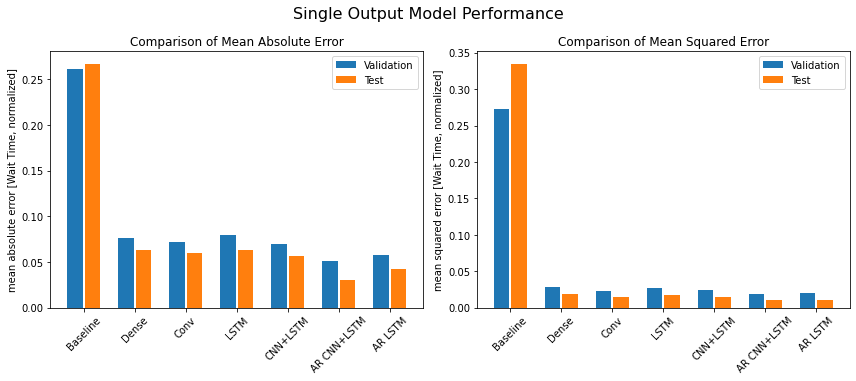

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]


metric_name = 'mean_squared_error'
metric_index = lstm_model.metrics_names.index('mean_squared_error')
val_mse = [v[metric_index] for v in val_performance.values()]
test_mse = [v[metric_index] for v in performance.values()]


metric_name = 'root_mean_squared_error'
metric_index = lstm_model.metrics_names.index('root_mean_squared_error')
val_rmse = [v[metric_index] for v in val_performance.values()]
test_rmse = [v[metric_index] for v in performance.values()]


metric_name = 'mean_absolute_percentage_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_percentage_error')
val_mape = [v[metric_index] for v in val_performance.values()]
test_mape = [v[metric_index] for v in performance.values()]

fig, ax = plt.subplots(1,2, figsize=(12, 5))
fig.subplots_adjust(top=0.8)

plt.subplot(1,2,1)
plt.title('Comparison of Mean Absolute Error')
plt.ylabel('mean absolute error [Wait Time, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

plt.subplot(1,2,2)
plt.title('Comparison of Mean Squared Error')
plt.ylabel('mean squared error [Wait Time, normalized]')
plt.bar(x - 0.17, val_mse, width, label='Validation')
plt.bar(x + 0.17, test_mse, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

fig.suptitle("Single Output Model Performance", y=1.05, size=16)
fig.tight_layout()

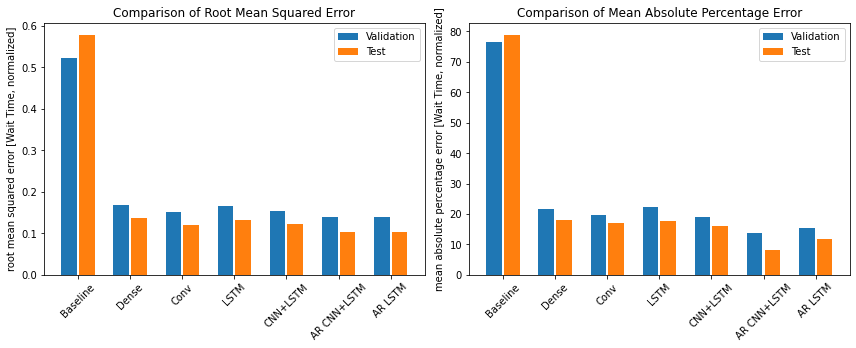

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
fig.subplots_adjust(top=0.8)

plt.subplot(1,2,1)
plt.title('Comparison of Root Mean Squared Error')
plt.ylabel('root mean squared error [Wait Time, normalized]')
plt.bar(x - 0.17, val_rmse, width, label='Validation')
plt.bar(x + 0.17, test_rmse, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

plt.subplot(1,2,2)
plt.title('Comparison of Mean Absolute Percentage Error')
plt.ylabel('mean absolute percentage error [Wait Time, normalized]')
plt.bar(x - 0.17, val_mape, width, label='Validation')
plt.bar(x + 0.17, test_mape, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
fig.tight_layout()

In [ ]:
method = ['------ MAE Comparison ------', '------ MSE Comparison ------', '------ RMSE Comparison ------', '------ MAPE Comparison ------']

for i in range(4):
  print(method[i])
  for name, value in performance.items():
    print(f'{name:12s}: {value[i+1]:0.4f}')

------ MAE Comparison ------
Baseline    : 0.2674
Dense       : 0.0638
Conv        : 0.0598
LSTM        : 0.0628
CNN+LSTM    : 0.0567
AR CNN+LSTM : 0.0307
AR LSTM     : 0.0426
------ MSE Comparison ------
Baseline    : 0.3351
Dense       : 0.0186
Conv        : 0.0143
LSTM        : 0.0171
CNN+LSTM    : 0.0148
AR CNN+LSTM : 0.0105
AR LSTM     : 0.0109
------ RMSE Comparison ------
Baseline    : 0.5789
Dense       : 0.1363
Conv        : 0.1194
LSTM        : 0.1309
CNN+LSTM    : 0.1218
AR CNN+LSTM : 0.1024
AR LSTM     : 0.1043
------ MAPE Comparison ------
Baseline    : 78.9040
Dense       : 18.1113
Conv        : 16.8647
LSTM        : 17.7603
CNN+LSTM    : 15.9252
AR CNN+LSTM : 8.2493
AR LSTM     : 11.7966


Multi-output models

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (256, 7, 4)
Labels shape (batch, time, features): (256, 7, 4)


In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsolutePercentageError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val, verbose=0)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

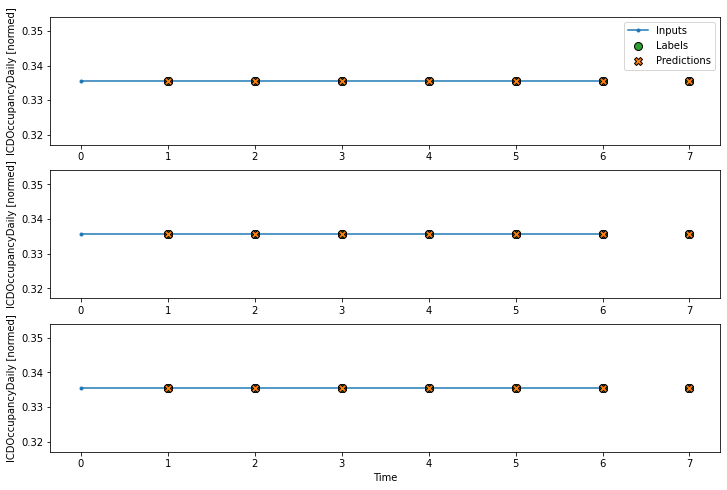

In [ ]:
wide_window.plot(baseline)

Dense model

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 48ms/step - loss: 0.2284 - mean_absolute_error: 0.2317 - mean_squared_error: 0.2284 - root_mean_squared_error: 0.4779 - mean_absolute_percentage_error: 40.6199


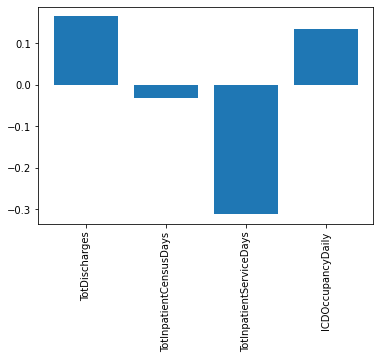

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=dense.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

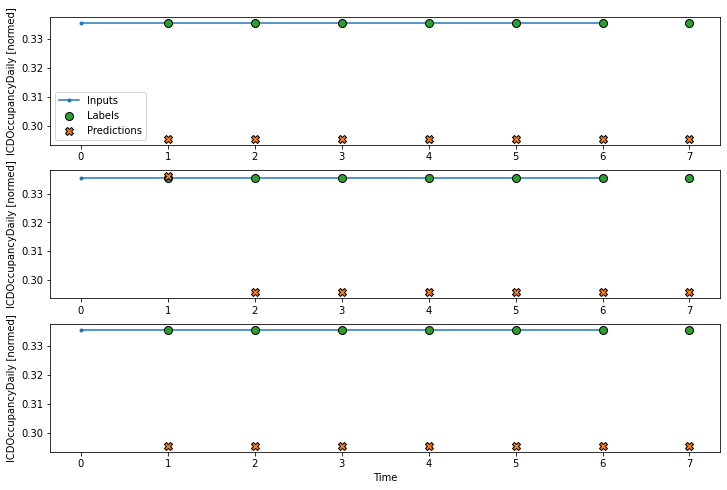

In [ ]:
wide_window.plot(dense)

Convolutional network

In [ ]:
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1)

wide_conv_window

Total window size: 10
Input indices: [0 1 2 3 4 5 6 7 8]
Label indices: [3 4 5 6 7 8 9]
Label column name(s): None

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features),
])

In [ ]:
history = compile_and_fit(conv_model, wide_conv_window)

val_performance['Conv'] = conv_model.evaluate(wide_conv_window.val)
performance['Conv'] = conv_model.evaluate(wide_conv_window.test, verbose=0)

1/1 [==============================] - 0s 57ms/step - loss: 0.2291 - mean_absolute_error: 0.2356 - mean_squared_error: 0.2291 - root_mean_squared_error: 0.4786 - mean_absolute_percentage_error: 41.5958


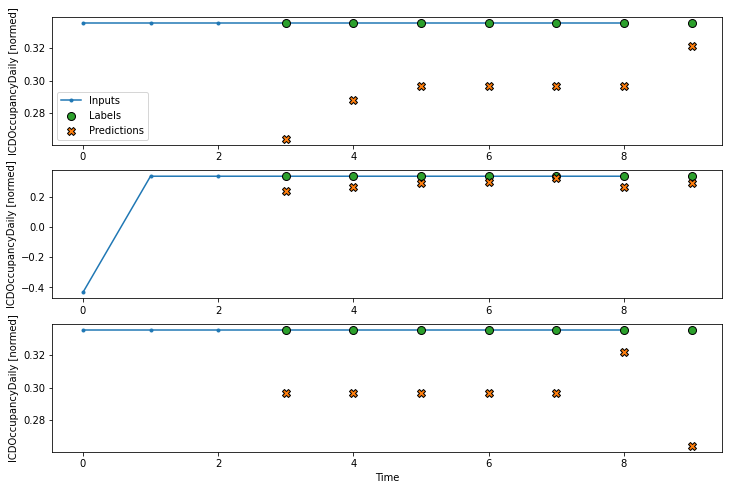

In [ ]:
wide_conv_window.plot(conv_model)

LSTM network

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

1/1 [==============================] - 0s 62ms/step - loss: 0.2326 - mean_absolute_error: 0.2534 - mean_squared_error: 0.2326 - root_mean_squared_error: 0.4823 - mean_absolute_percentage_error: 46.7416


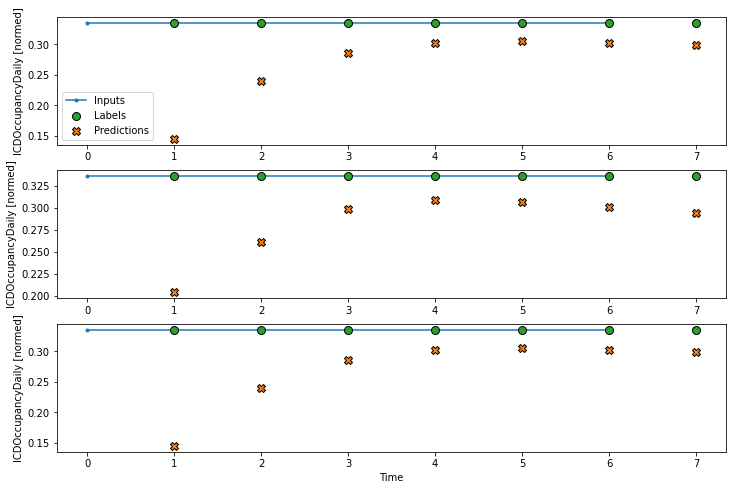

In [ ]:
wide_window.plot(lstm_model)

LSTM with Residual connections

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 58ms/step - loss: 0.2334 - mean_absolute_error: 0.2398 - mean_squared_error: 0.2334 - root_mean_squared_error: 0.4831 - mean_absolute_percentage_error: 43.0486


Autoregressive model

In [ ]:
OUT_STEPS = 1

feedback_model = FeedBack(units=64, out_steps=OUT_STEPS)
history = compile_and_fit(feedback_model, wide_window)

val_performance['AR LSTM'] = feedback_model.evaluate(wide_window.val)
performance['AR LSTM'] = feedback_model.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 54ms/step - loss: 0.2048 - mean_absolute_error: 0.1905 - mean_squared_error: 0.2048 - root_mean_squared_error: 0.4525 - mean_absolute_percentage_error: 30.7440


Comparison of multiple output models

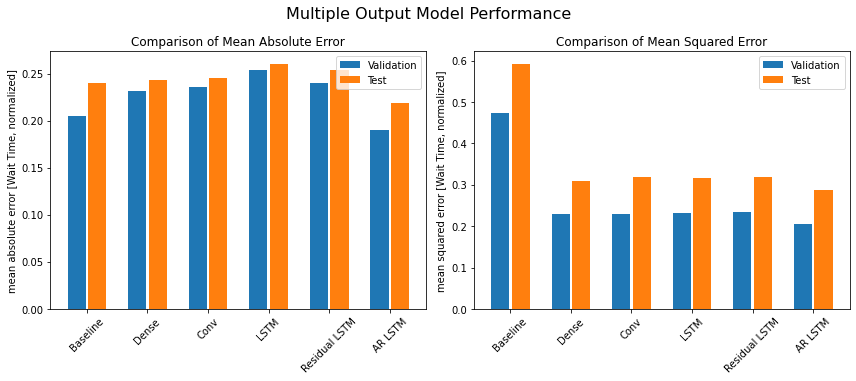

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]


metric_name = 'mean_squared_error'
metric_index = lstm_model.metrics_names.index('mean_squared_error')
val_mse = [v[metric_index] for v in val_performance.values()]
test_mse = [v[metric_index] for v in performance.values()]


metric_name = 'root_mean_squared_error'
metric_index = lstm_model.metrics_names.index('root_mean_squared_error')
val_rmse = [v[metric_index] for v in val_performance.values()]
test_rmse = [v[metric_index] for v in performance.values()]


metric_name = 'mean_absolute_percentage_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_percentage_error')
val_mape = [v[metric_index] for v in val_performance.values()]
test_mape = [v[metric_index] for v in performance.values()]

fig, ax = plt.subplots(1,2, figsize=(12, 5))
fig.subplots_adjust(top=0.8)

plt.subplot(1,2,1)
plt.title('Comparison of Mean Absolute Error')
plt.ylabel('mean absolute error [Wait Time, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

plt.subplot(1,2,2)
plt.title('Comparison of Mean Squared Error')
plt.ylabel('mean squared error [Wait Time, normalized]')
plt.bar(x - 0.17, val_mse, width, label='Validation')
plt.bar(x + 0.17, test_mse, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

fig.suptitle("Multiple Output Model Performance", y=1.05, size=16)
fig.tight_layout()

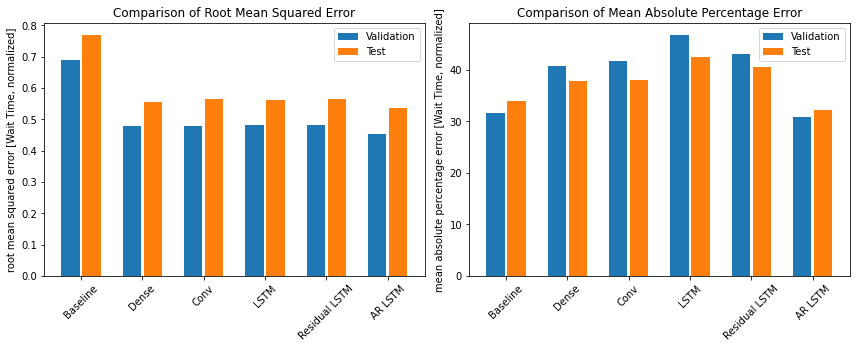

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
fig.subplots_adjust(top=0.8)

plt.subplot(1,2,1)
plt.title('Comparison of Root Mean Squared Error')
plt.ylabel('root mean squared error [Wait Time, normalized]')
plt.bar(x - 0.17, val_rmse, width, label='Validation')
plt.bar(x + 0.17, test_rmse, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

plt.subplot(1,2,2)
plt.title('Comparison of Mean Absolute Percentage Error')
plt.ylabel('mean absolute percentage error [Wait Time, normalized]')
plt.bar(x - 0.17, val_mape, width, label='Validation')
plt.bar(x + 0.17, test_mape, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
fig.tight_layout()

In [ ]:
method = ['------ MAE Comparison ------', '------ MSE Comparison ------', '------ RMSE Comparison ------', '------ MAPE Comparison ------']

for i in range(4):
  print(method[i])
  for name, value in performance.items():
    print(f'{name:12s}: {value[i+1]:0.4f}')

------ MAE Comparison ------
Baseline    : 0.2403
Dense       : 0.2431
Conv        : 0.2455
LSTM        : 0.2606
Residual LSTM: 0.2534
AR LSTM     : 0.2191
------ MSE Comparison ------
Baseline    : 0.5924
Dense       : 0.3096
Conv        : 0.3184
LSTM        : 0.3170
Residual LSTM: 0.3175
AR LSTM     : 0.2875
------ RMSE Comparison ------
Baseline    : 0.7697
Dense       : 0.5564
Conv        : 0.5643
LSTM        : 0.5630
Residual LSTM: 0.5635
AR LSTM     : 0.5362
------ MAPE Comparison ------
Baseline    : 33.8181
Dense       : 37.7949
Conv        : 38.0606
LSTM        : 42.5371
Residual LSTM: 40.5410
AR LSTM     : 32.0910


Multi-step models

Total window size: 14
Input indices: [0 1 2 3 4 5 6]
Label indices: [ 7  8  9 10 11 12 13]
Label column name(s): ['ICDOccupancyDaily']

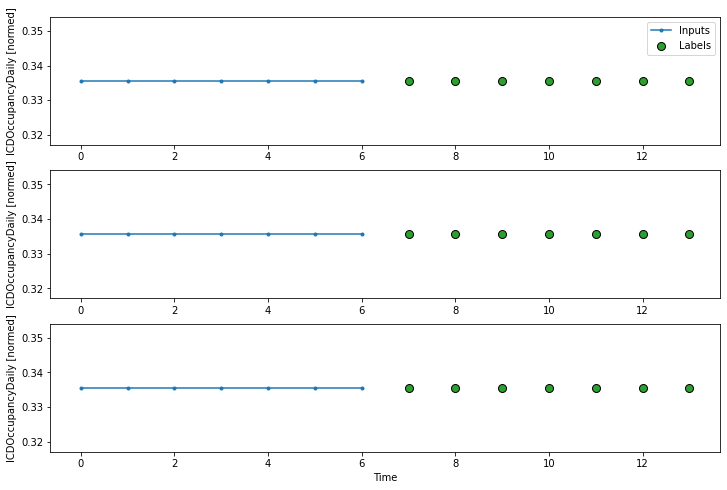

In [ ]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=7,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['ICDOccupancyDaily'])

multi_window.plot()
multi_window

Baseline model

1/1 [==============================] - 0s 167ms/step - loss: 0.2865 - mean_absolute_error: 0.2730 - mean_squared_error: 0.2865 - root_mean_squared_error: 0.5352 - mean_absolute_percentage_error: 79.7657


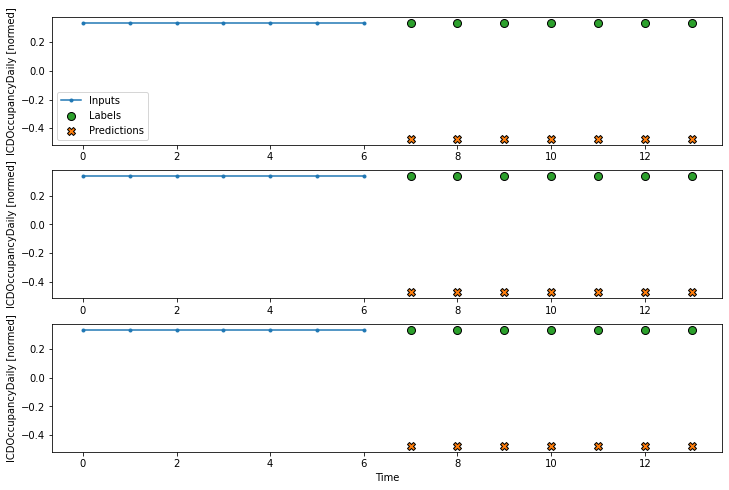

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsolutePercentageError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

1/1 [==============================] - 0s 157ms/step - loss: 0.2828 - mean_absolute_error: 0.2695 - mean_squared_error: 0.2828 - root_mean_squared_error: 0.5318 - mean_absolute_percentage_error: 78.6582


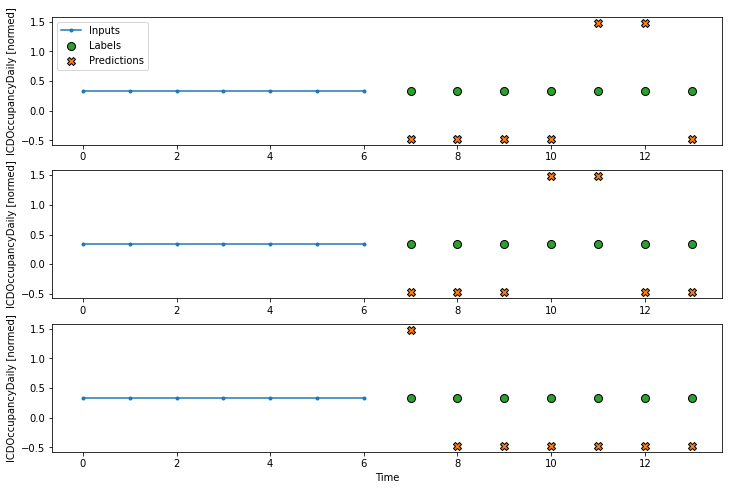

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsolutePercentageError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

Linear

1/1 [==============================] - 0s 54ms/step - loss: 0.0497 - mean_absolute_error: 0.1774 - mean_squared_error: 0.0497 - root_mean_squared_error: 0.2229 - mean_absolute_percentage_error: 51.2159


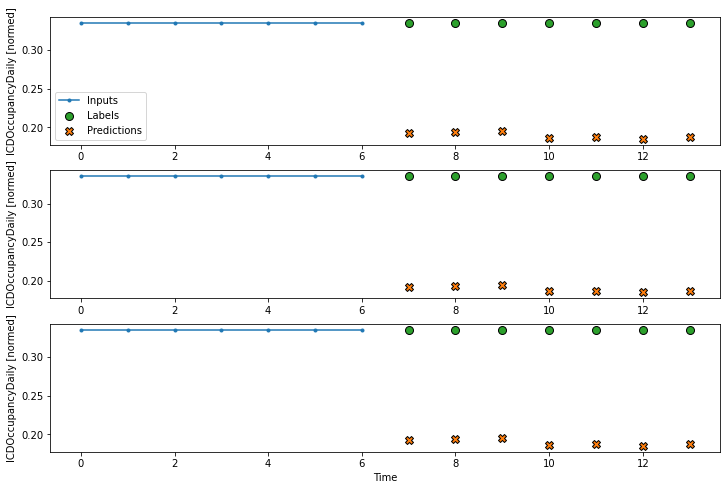

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

Dense

1/1 [==============================] - 0s 49ms/step - loss: 0.0503 - mean_absolute_error: 0.1153 - mean_squared_error: 0.0503 - root_mean_squared_error: 0.2244 - mean_absolute_percentage_error: 32.5072


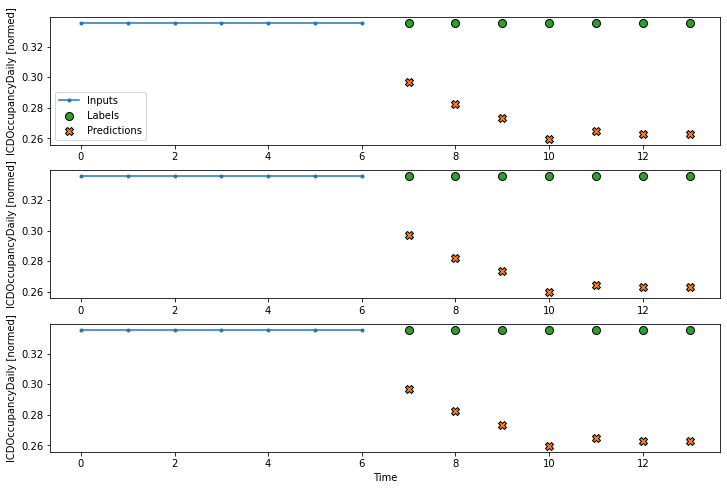

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(1024, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

Convolutional neural network

1/1 [==============================] - 0s 53ms/step - loss: 0.0334 - mean_absolute_error: 0.0985 - mean_squared_error: 0.0334 - root_mean_squared_error: 0.1827 - mean_absolute_percentage_error: 27.4172


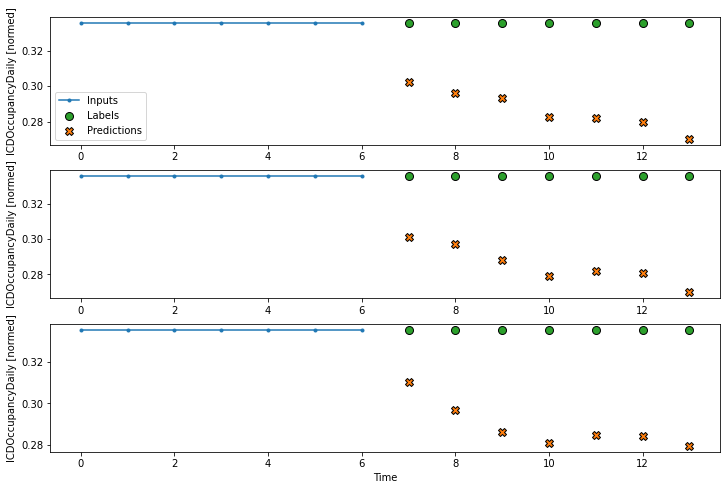

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

LSTM

1/1 [==============================] - 0s 53ms/step - loss: 0.0303 - mean_absolute_error: 0.1321 - mean_squared_error: 0.0303 - root_mean_squared_error: 0.1741 - mean_absolute_percentage_error: 37.4941


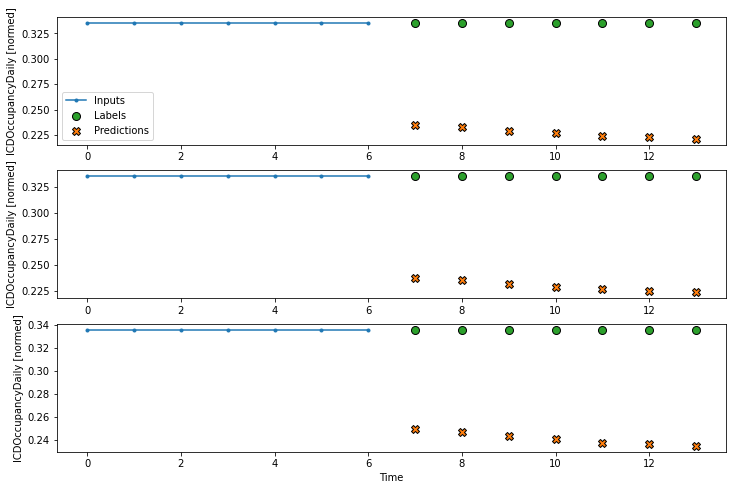

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(128, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

Autoregressive model

In [ ]:
OUT_STEPS = 7

feedback_model = FeedBack(units=64, out_steps=OUT_STEPS)

1/1 [==============================] - 0s 56ms/step - loss: 0.0270 - mean_absolute_error: 0.1018 - mean_squared_error: 0.0270 - root_mean_squared_error: 0.1643 - mean_absolute_percentage_error: 28.3822


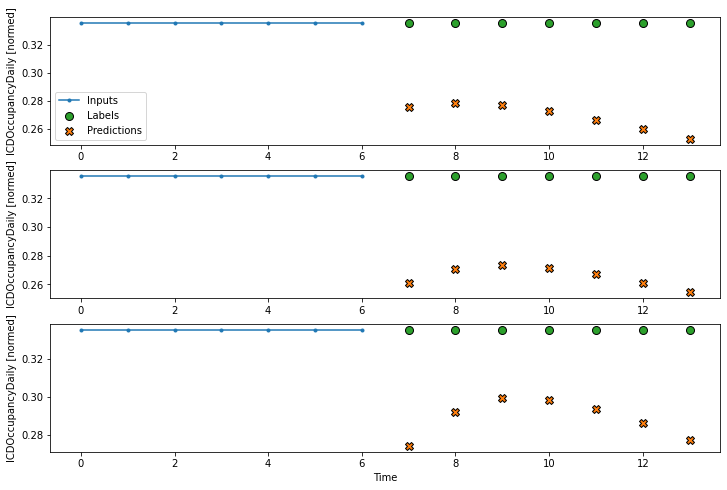

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

Comparison of performance

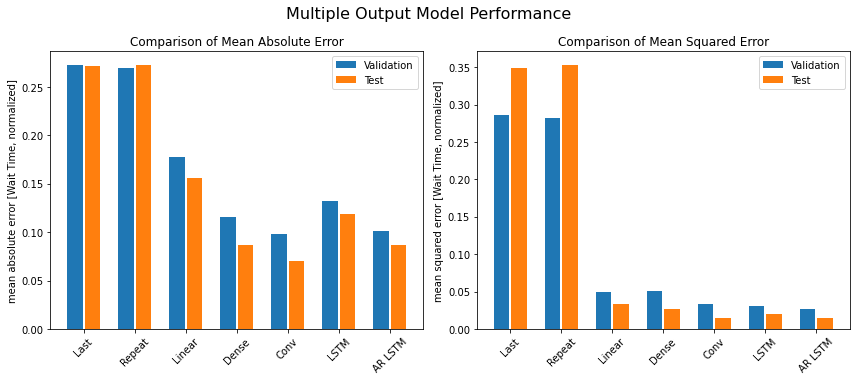

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

metric_name = 'mean_squared_error'
metric_index = multi_lstm_model.metrics_names.index('mean_squared_error')
val_mse = [v[metric_index] for v in multi_val_performance.values()]
test_mse = [v[metric_index] for v in multi_performance.values()]

metric_name = 'root_mean_squared_error'
metric_index = multi_lstm_model.metrics_names.index('root_mean_squared_error')
val_rmse = [v[metric_index] for v in multi_val_performance.values()]
test_rmse = [v[metric_index] for v in multi_performance.values()]


metric_name = 'mean_absolute_percentage_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_percentage_error')
val_mape = [v[metric_index] for v in multi_val_performance.values()]
test_mape = [v[metric_index] for v in multi_performance.values()]

fig, ax = plt.subplots(1,2, figsize=(12, 5))
fig.subplots_adjust(top=0.8)

plt.subplot(1,2,1)
plt.title('Comparison of Mean Absolute Error')
plt.ylabel('mean absolute error [Wait Time, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
_ = plt.legend()

plt.subplot(1,2,2)
plt.title('Comparison of Mean Squared Error')
plt.ylabel('mean squared error [Wait Time, normalized]')
plt.bar(x - 0.17, val_mse, width, label='Validation')
plt.bar(x + 0.17, test_mse, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
_ = plt.legend()

fig.suptitle("Multiple Output Model Performance", y=1.05, size=16)
fig.tight_layout()

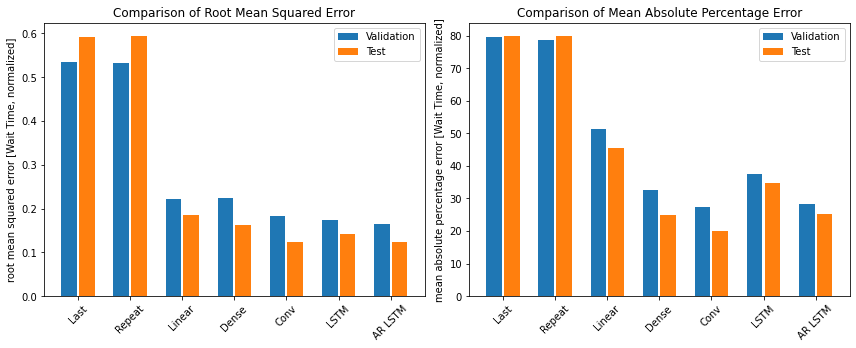

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
fig.subplots_adjust(top=0.8)

plt.subplot(1,2,1)
plt.title('Comparison of Root Mean Squared Error')
plt.ylabel('root mean squared error [Wait Time, normalized]')
plt.bar(x - 0.17, val_rmse, width, label='Validation')
plt.bar(x + 0.17, test_rmse, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
_ = plt.legend()

plt.subplot(1,2,2)
plt.title('Comparison of Mean Absolute Percentage Error')
plt.ylabel('mean absolute percentage error [Wait Time, normalized]')
plt.bar(x - 0.17, val_mape, width, label='Validation')
plt.bar(x + 0.17, test_mape, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
_ = plt.legend()
fig.tight_layout()

In [ ]:
method = ['------ MAE Comparison ------', '------ MSE Comparison ------', '------ RMSE Comparison ------', '------ MAPE Comparison ------']

for i in range(4):
  print(method[i])
  for name, value in multi_performance.items():
    print(f'{name:12s}: {value[i+1]:0.4f}')

------ MAE Comparison ------
Last        : 0.2715
Repeat      : 0.2724
Linear      : 0.1558
Dense       : 0.0869
Conv        : 0.0703
LSTM        : 0.1192
AR LSTM     : 0.0871
------ MSE Comparison ------
Last        : 0.3489
Repeat      : 0.3535
Linear      : 0.0341
Dense       : 0.0264
Conv        : 0.0156
LSTM        : 0.0198
AR LSTM     : 0.0151
------ RMSE Comparison ------
Last        : 0.5907
Repeat      : 0.5945
Linear      : 0.1847
Dense       : 0.1624
Conv        : 0.1247
LSTM        : 0.1408
AR LSTM     : 0.1229
------ MAPE Comparison ------
Last        : 79.9844
Repeat      : 79.9098
Linear      : 45.6616
Dense       : 25.0370
Conv        : 20.0938
LSTM        : 34.7363
AR LSTM     : 25.1216
